# 3.3.4. Learning noise parameters with transforms

In this notebook, we demonstrate how transforms can be trained to apply corrective operations in situations where a device is noisy.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

First we define a qfunc transform that applies qubit-dependent depolarizing noise. 

In [2]:
@qml.qfunc_transform
def apply_depolarizing_noise(tape, p):
    for op in tape.operations:
        qml.apply(op)
        
        if len(op.wires) == 1:
            qml.DepolarizingChannel(
                p[int(op.wires[0])], wires=op.wires[0]
            )
            
    for m in tape.measurements:
        qml.apply(m)

Define a simple test circuit that acts on two qubits.

In [3]:
def circuit(angles):
    qml.RX(angles[0], wires=0)
    qml.RY(angles[1], wires=1)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

Below, we establish a noisy device with depolarization strengths specified. In principle this could be a real hardware device, but for our purposes here, we will simulate it.

In [4]:
true_deps = np.array([0.05, 0.02])

noisy_dev = qml.device('default.mixed', wires=2, shots=10000)
noisy_circuit = apply_depolarizing_noise(true_deps)(circuit)
noisy_qnode = qml.QNode(noisy_circuit, noisy_dev)

We now set up a noiseless device. It will apply the depolarization during the training process and behave as a model of our noisy device. We define a cost function that compares the outputs of the two devices (if the results are the same, the cost will be minimized). 

In [5]:
# Arbitrary parameters to evaluate the QNode at
angles = np.array([0.2, 0.3], requires_grad=False)

ideal_dev = qml.device('default.mixed', wires=2)

def cost(learn_eps):
    # The QNode below runs the circuit with depolarizing noise on the ideal 
    # device, and tries to match the results of the noisy device.
    training_qnode = qml.QNode(apply_depolarizing_noise(learn_eps)(circuit), ideal_dev)
    return sum((training_qnode(angles) - noisy_qnode(angles)) ** 2)

Below we set up the training loop.

In [6]:
opt = qml.GradientDescentOptimizer(stepsize=0.05)
correction_eps = np.array([0.1, 0.1], requires_grad=True)

eps_training = [correction_eps]

np.random.seed(0) # For reproducibility

for _ in range(100):
    correction_eps = np.clip(correction_eps, 0, 1)
    correction_eps = opt.step(cost, correction_eps)
    eps_training.append(correction_eps)
    
eps_training = np.array(eps_training)

In [7]:
correction_eps

tensor([0.04973839, 0.02163015], requires_grad=True)

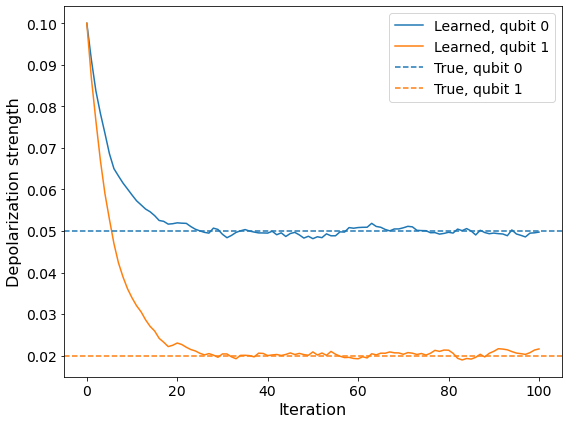

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(eps_training[:,0], label="Learned, qubit 0")
plt.plot(eps_training[:,1], label="Learned, qubit 1")
plt.axhline(y=true_deps[0], label="True, qubit 0", color="tab:blue", linestyle="--")
plt.axhline(y=true_deps[1], label="True, qubit 1", color="tab:orange", linestyle="--")
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Depolarization strength", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()